# Early Diabetes Detection Using Symptoms

### <u>Dataset Description</u>
This dataset is originally from <a href="https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.#">UCI Machine Learning Repository</a>. It contains the sign and symptpom data of newly diabetic or would be diabetic patient. 

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from IPython.display import display, HTML

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.weightstats import ztest
# import scipy 
# from scipy.stats import chi2_contingency
from scipy import stats
from scipy import interp

from collections import Counter
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.metrics import recall_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier as DT 
from sklearn.ensemble import RandomForestClassifier as RF 
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier 
from sklearn.naive_bayes import GaussianNB as GB  
from sklearn.svm import SVC   
import pickle

In [2]:
diabetes_df = pd.read_csv("../dataset/early_detection_diabetes_data.csv")

# Descriptive Statistics

In [3]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

From the result above, only 'Age' column has numerical values as its input, while other columns have categorical inputs.

In [4]:
diabetes_df.columns = diabetes_df.columns.str.lower()

In [5]:
diabetes_df.sample(5)

,age,gender,polyuria,polydipsia,sudden weight loss,weakness,polyphagia,genital thrush,visual blurring,itching,irritability,delayed healing,partial paresis,muscle stiffness,alopecia,obesity,class
379,62,Male,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,Positive
334,46,Male,No,No,No,Yes,No,No,No,Yes,No,Yes,No,No,Yes,No,Negative
22,39,Male,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Yes,No,Positive
199,69,Female,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,No,Yes,No,Yes,Positive
9,70,Male,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,No,Positive


In [6]:
pos = round(diabetes_df[diabetes_df['class']=='Positive'].describe(include='all'),2)
neg = round(diabetes_df[diabetes_df['class']=='Negative'].describe(include='all'),2)
pos_neg = pd.concat([pos, neg], axis=1, keys=['Positive','Negative'])
with pd.option_context('display.max_columns', None):
    display(HTML(pos_neg.to_html()))

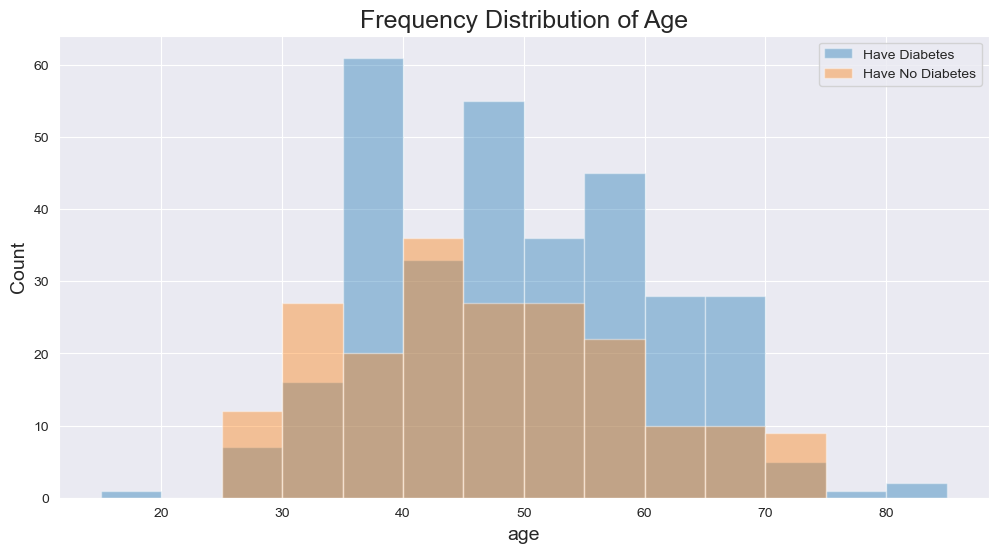

In [7]:
plt.figure(figsize=(12,6))
plt.hist(diabetes_df[diabetes_df['class']=='Positive']['age'], alpha=0.4, bins=np.arange(15, 90, 5),label='Have Diabetes')
plt.hist(diabetes_df[diabetes_df['class']=='Negative']['age'], alpha=0.4, bins=np.arange(15, 90, 5),label='Have No Diabetes')
plt.title('Frequency Distribution of Age',fontsize=18)
plt.xlabel('age',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.legend();

In [8]:
diabetes_df[(diabetes_df['class']=='Positive') & (diabetes_df['age']<=20) | (diabetes_df['age']>=75)]

,age,gender,polyuria,polydipsia,sudden weight loss,weakness,polyphagia,genital thrush,visual blurring,itching,irritability,delayed healing,partial paresis,muscle stiffness,alopecia,obesity,class
101,85,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,Positive
102,90,Female,No,Yes,Yes,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,Positive
113,79,Male,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,Positive
133,16,Male,Yes,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,Positive
185,85,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,Positive
186,90,Female,No,Yes,Yes,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,Positive


* Based on the frequency distribution of age, we found out that most of people who have diabetes have age of 35-39. There are also patients who aged of 16 as well as between 75 and 90 in the dataset. 
* Based on the extraction of data above, it is found that all of these minority patients sufferred from sudden weight loss and did not suffer from obesity. Hence, it is suspected that sudden weight loss would be an important variable in the diabetes detection analysis, and vice versa for the obesity variable. However, it requires further analysis to confirm these relationships.

# Multivariate Analysis & Hypothesis Testing

In [9]:
labelencoder = LabelEncoder()
for i in diabetes_df[1:]:
    diabetes_df[i] = labelencoder.fit_transform(diabetes_df[i])

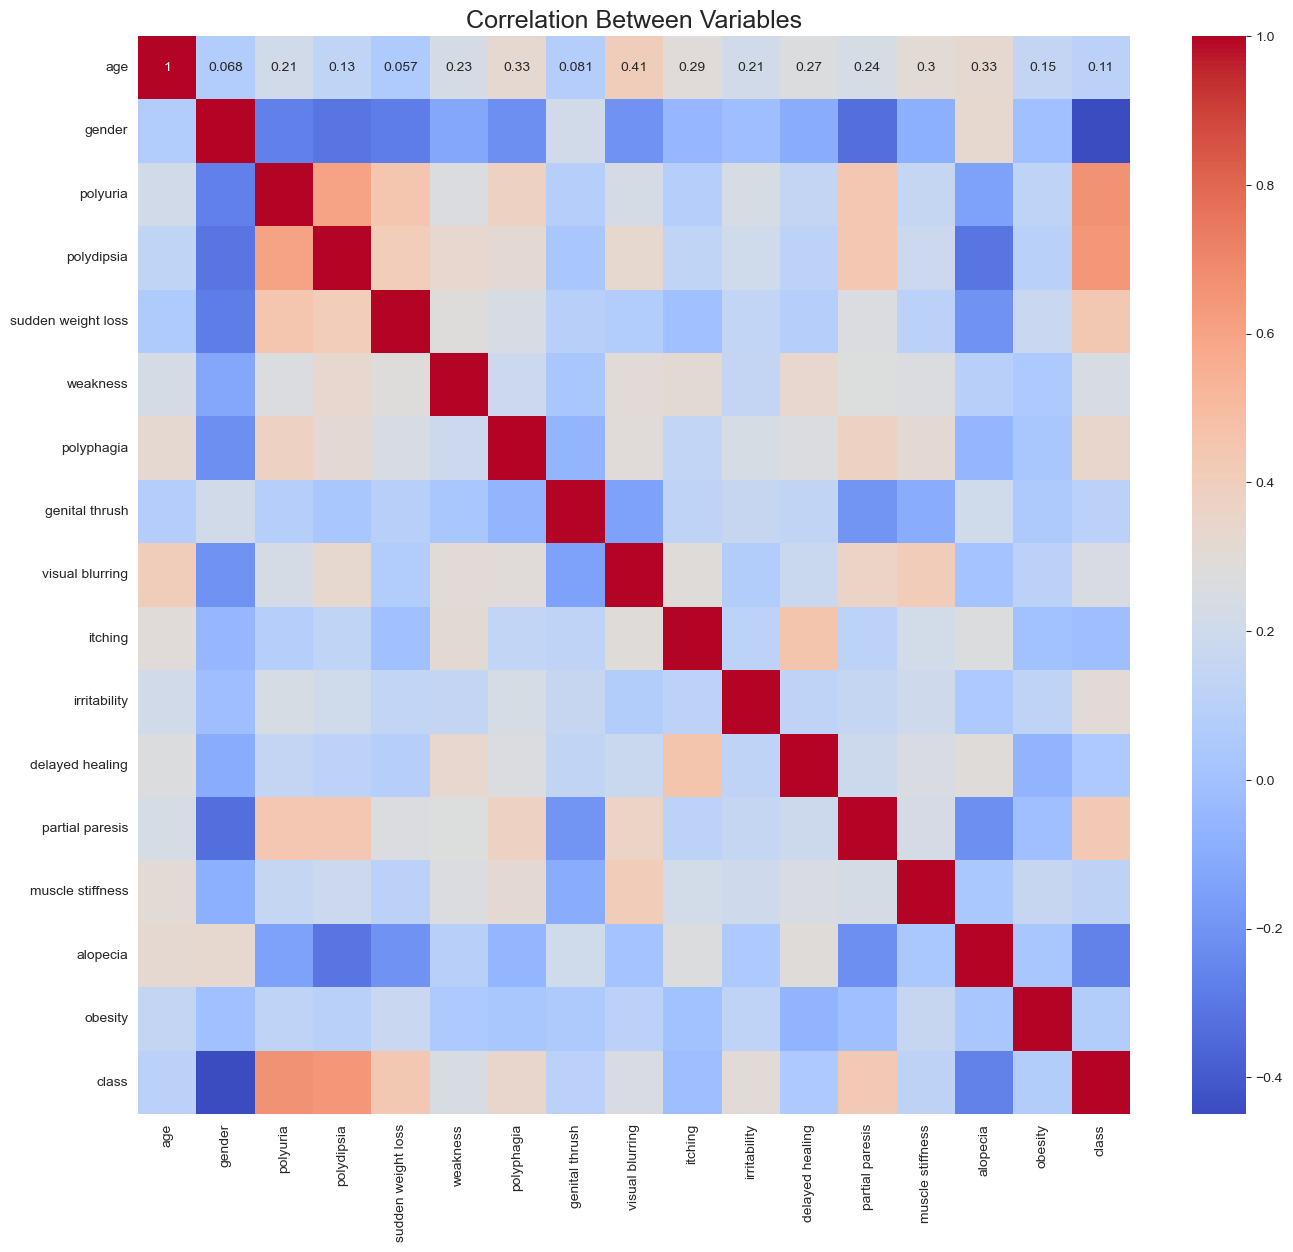

In [10]:
plt.figure(figsize = (16,14))
sns.heatmap(diabetes_df.corr(), annot=True, fmt='.2g',cmap='coolwarm')
plt.title('Correlation Between Variables', fontsize=18);

In [11]:
diabetes_obesity_crosstab = pd.crosstab(diabetes_df['obesity'], diabetes_df['class'])
Chisquares_diabetes_obesity = stats.chi2_contingency(diabetes_obesity_crosstab)
Chisquares_diabetes_obesity

Chi2ContingencyResult(statistic=2.327473958333334, pvalue=0.12710799319896815, dof=1, expected_freq=array([[166.15384615, 265.84615385],
       [ 33.84615385,  54.15384615]]))

* The chi-squared test between obesity & diabetes status showed that p-value = 0.13 > 0.05. 
* Hence, we cannot reject the null hypothesis and we cannot say that there is no significant relationship between obesity & diabetes. For this reason, I would exclude obesity from the model building.

In [12]:
gender_obesity_crosstab = pd.crosstab(diabetes_df['gender'], diabetes_df['class'])
Chisquares_gender_obesity = stats.chi2_contingency(gender_obesity_crosstab)
Chisquares_gender_obesity

Chi2ContingencyResult(statistic=103.03685927972559, pvalue=3.289703730553294e-24, dof=1, expected_freq=array([[ 73.84615385, 118.15384615],
       [126.15384615, 201.84615385]]))

* The chi-squared test between gender & diabetes status showed that p-value = 3.29e-24 < 0.05
* Hence, we can reject the null hypothesis and we can say that there is a significant relationship between gender & diabetes.

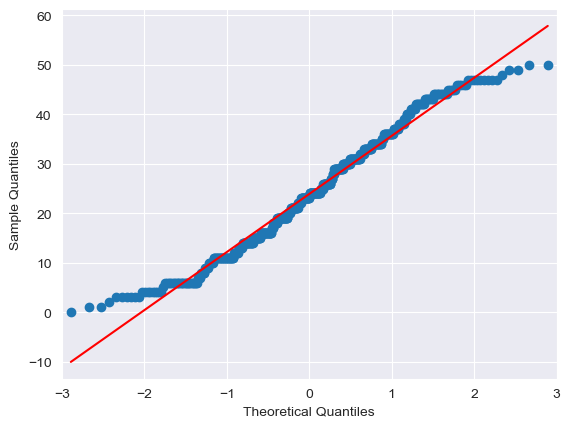

In [13]:
qqplot(diabetes_df['age'],line='s')
plt.show()

In [14]:
stats.shapiro(diabetes_df['age']) 

ShapiroResult(statistic=0.978580892086029, pvalue=6.471887559200695e-07)

* Based on the qqplot (most points lied on the line) and the Shapiro result which showed that the p-value = 6.47e-07 < 0.05
* We can say that the distribution of the age is normally distributed and we can conduct the z-test.

In [15]:
w_diabetes = diabetes_df[diabetes_df['class']==1]
n_diabetes = diabetes_df[diabetes_df['class']==0] 
ztest(w_diabetes['age'], n_diabetes['age'])

(2.4358875641213964, 0.014855301229383732)

* With p-value = 0.014 < 0.05, we will reject the null hypothesis
* It is said that there is significant difference in the mean of age between people with diabetes and people without diabetes.

In [16]:
diabetes_df = pd.read_csv("../dataset/early_detection_diabetes_data.csv")
diabetes_df.columns = diabetes_df.columns.str.lower()

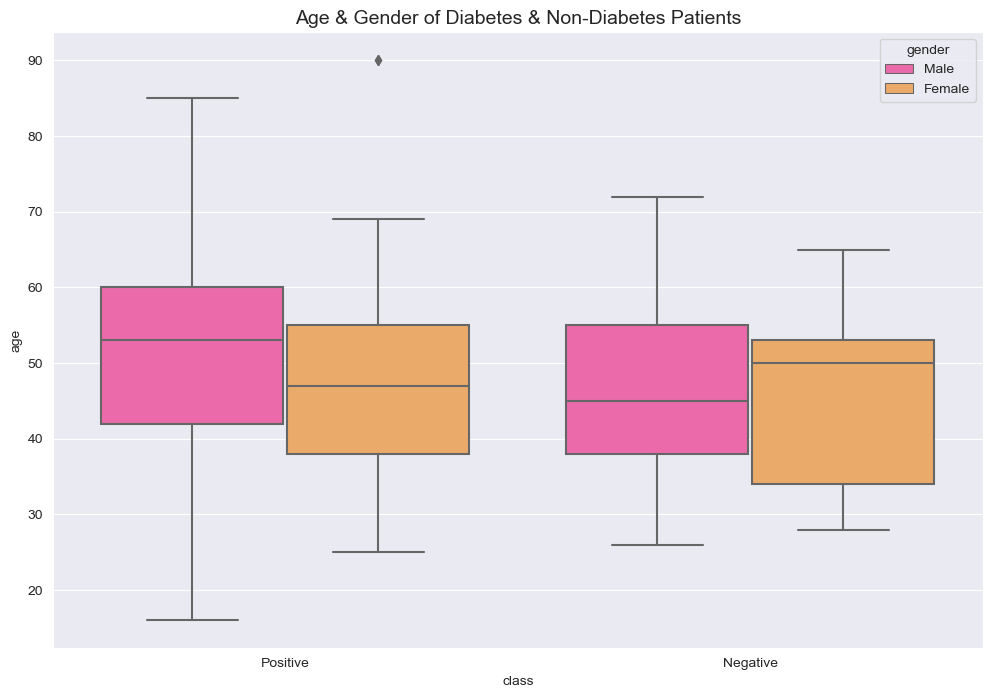

In [17]:
plt.figure(figsize=(12,8))
a = sns.boxplot(y='age', x='class', hue='gender',data=diabetes_df, palette='spring')
plt.title("Age & Gender of Diabetes & Non-Diabetes Patients", fontsize=14);

# Model Building & Evaluation

In [18]:
X = diabetes_df.drop(['class','obesity'], axis=1)
Y = diabetes_df['class'].map({'Negative':0,'Positive':1})

In [19]:
num_cols = ['age']
cat_cols = list(X.drop(['age'], axis=1))

full_pipeline = ColumnTransformer([
        ("num", MinMaxScaler(), num_cols),
        ("cat", OneHotEncoder(sparse_output=False, dtype='int', drop="if_binary"), cat_cols)])

In [20]:
# Create training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

In [21]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [22]:
classifiers = []
log_reg = LogisticRegression(max_iter=10000)
classifiers.append(log_reg)
knn_neg = KNeighborsClassifier(metric='euclidean') 
classifiers.append(knn_neg)
dt_model = DT(random_state=42)
classifiers.append(dt_model)
rf_model = RF(random_state=42)
classifiers.append(rf_model)
ab_model=AdaBoostClassifier(random_state=42)
classifiers.append(ab_model)
xgb_model = XGBClassifier(random_state=42)
classifiers.append(xgb_model)
GNB_model = GB() 
classifiers.append(GNB_model)
SVM_model = SVC(random_state=42)
classifiers.append(SVM_model)
classifiers

[LogisticRegression(max_iter=10000),
 KNeighborsClassifier(metric='euclidean'),
 DecisionTreeClassifier(random_state=42),
 RandomForestClassifier(random_state=42),
 AdaBoostClassifier(random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=42, ...),
 GaussianNB(),
 SVC(random_state=42)

In [23]:
recall_train = []
recall_test = []
for clf in classifiers:
    clf.fit(X_train, Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    rn = round(recall_score(Y_train, pred_train, average='macro')*100,2)
    rt = round(recall_score(Y_test, pred_test, average='macro')*100,2)
    recall_train.append(rn)
    recall_test.append(rt)

In [24]:
original_result = pd.DataFrame(data={'Model':['LR','KNN','DT','RF','AdaBoost','XGB','Gaussian Bayes','SVM'],
                                     'Recall-Macro_Training (%)':recall_train,
                                     'Recall-Macro_Test (%)':recall_test})
original_result.sort_values(by=['Recall-Macro_Test (%)'],ascending=False)

,Model,Recall-Macro_Training (%),Recall-Macro_Test (%)
3,RF,100.00,98.00
5,XGB,100.00,97.75
2,DT,100.00,96.38
7,SVM,97.92,95.50
4,AdaBoost,95.38,93.62
1,KNN,95.92,92.62
0,LR,95.04,92.00
6,Gaussian Bayes,89.79,90.62


From the results above, it is clearly seen that the decision tree, random forest and xgb models have **overfitting** problems, as they are unable to generalize well and they only outperform when training data is used. To avoid overfitting problem, **cross-validation** is performed in the following step.

In [25]:
rc_mean_cv = []
rc_std_cv = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i in classifiers:
    score = cross_val_score(i,X_train,Y_train,scoring='recall_macro', cv=kf)
    rc_mean_cv.append(round(score.mean()*100,2))
    rc_std_cv.append(round(score.std()*100,2))

In [26]:
cv_result = pd.DataFrame(data={'Model':['LR','KNN','DT','RT','AdaBoost','XGB','GNB','SVM'],
                               'Recall-Macro_Mean(%)':rc_mean_cv,
                               'Recall-Macro_SDev(%)':rc_std_cv})
cv_result.sort_values(['Recall-Macro_Mean(%)','Recall-Macro_SDev(%)'],ascending=False)

,Model,Recall-Macro_Mean(%),Recall-Macro_SDev(%)
3,RT,96.75,2.31
5,XGB,95.71,1.85
7,SVM,95.67,1.78
2,DT,95.46,2.82
1,KNN,94.75,1.52
0,LR,94.42,0.98
4,AdaBoost,91.58,2.88
6,GNB,89.46,1.88


* Based on the cross-validation result above, only SVC, decision tree and random forest classifiers have recall of more than or equal to 96%. 
* However, the decision tree classifier is doing a better job than the SVC and random forest classifiers as it has lower standard deviation (how much the predicted value differ from the actual value). 

### Handling imbalanced class with SMOTE-based techniques

In [27]:
diabetes_df['class'].value_counts()

class
Positive    320
Negative    200
Name: count, dtype: int64

* There is imbalanced class in the dataset, where the majority class belongs to the “0” (we denoted it as negative) label and the minority class belongs to the “1” (we denoted it as positive) label. 
* Hence, SMOTE based techniques (`SMOTE`, `ADASYN`, `SMOTEENN`, `SMOTETomek`) would be used to overcome this issue on the random forest model. 

In [28]:
# SMOTE
counter = Counter(Y_train)
print('Before',counter)
smt=SMOTE(random_state=42)
X_train_sm, Y_train_sm = smt.fit_resample(X_train, Y_train)
counter = Counter(Y_train_sm)
print('After',counter)

Before Counter({1: 240, 0: 150})
After Counter({1: 240, 0: 240})


In [29]:
# ADASYN
counter = Counter(Y_train)
print('Before',counter)
ada=ADASYN(random_state=42)
X_train_ada, Y_train_ada=ada.fit_resample(X_train, Y_train)
counter = Counter(Y_train_ada)
print('After',counter)

Before Counter({1: 240, 0: 150})
After Counter({1: 240, 0: 237})


In [30]:
# SMOTE-ENN
counter = Counter(Y_train)
print('Before',counter)
smenn=SMOTEENN(random_state=42)
X_train_smenn, Y_train_smenn=smenn.fit_resample(X_train, Y_train)
counter = Counter(Y_train_smenn)
print('After',counter)

Before Counter({1: 240, 0: 150})
After Counter({0: 232, 1: 215})


In [31]:
# SMOTE-TOMEK 
counter = Counter(Y_train)
print('Before',counter)
smtom=SMOTETomek(random_state=42)
X_train_smtom, Y_train_smtom=smtom.fit_resample(X_train, Y_train)
counter = Counter(Y_train_smtom)
print('After',counter)

Before Counter({1: 240, 0: 150})
After Counter({1: 239, 0: 239})


* Above are the SMOTE-based techniques to be used to handle imbalanced data. 
* Below is the function which involved: 
 1. Pipeline to handle the inbalanced dataset, scale the data, and run the data with a set of classifiers one by one. 
 2. Hyperparameter tuning process with 5-fold cross validation for each classifier to select the best model and its best parameters with the `PipelineHelper`. 

In [32]:
from imblearn.pipeline import make_pipeline

In [33]:
def diabetes_prediction(X,Y,smote=False, adasyn=False, smote_enn=False, smote_tomek=False):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)
    
    trf = ColumnTransformer(transformers =[('cat',OneHotEncoder(sparse_output = False, drop ='first'),
                                               ['gender','polyuria','polydipsia','sudden weight loss',
                                                'weakness','polyphagia','genital thrush','visual blurring',
                                                'itching','irritability','delayed healing','partial paresis',
                                                'muscle stiffness','alopecia']),
                                           ('num',MinMaxScaler(), ['age'])],
                            remainder='passthrough')
    
    clfs = [('log_reg', LogisticRegression(max_iter=10000)),
           ('knn_neg', KNeighborsClassifier(metric='euclidean')),
           ('dt_model', DT(random_state=42)),
           ('rf_model', RF(random_state=42)),
           ('ab_model', AdaBoostClassifier(random_state=42)),
           ('xgb_model', XGBClassifier(random_state=42)),
           ('GNB_model', GB()),
           ('SVM_model', SVC(random_state=42))]
    
    params = {'log_reg__C':np.logspace(-10, 1, 15),
                     'log_reg__penalty':['l1','l2'],
                     'knn_neg__n_neighbors': [2, 3, 5, 7, 10],
                     'knn_neg__leaf_size': [1, 2, 3, 5],
#                      'knn_neg__weights': ['uniform','distance'],
                     'dt_model__max_depth':[i for i in range(5,16,2)],
                     'dt_model__min_samples_split':[2, 5, 10, 15, 20, 50],
                     'dt_model__min_samples_leaf':[1, 2, 5],
                     'dt_model__max_features': [1,3,6],
                     'rf_model__max_depth': [3, 10, 30],
                     'rf_model__n_estimators': [10, 20, 50, 100, 150],
                     'rf_model__max_features':  [i for i in range(5,20,2)],
                     'ab_model__n_estimators': [10, 20, 40, 100],
                     'ab_model__algorithm': ['SAMME', 'SAMME.R'],
                     'xgb_model__n_estimators': [10, 20, 50, 100],
                     'xgb_model__max_depth': [3, 10, 30],
                     'xgb_model__gamma': [3,5,7,9],
                     'xgb_model__min_child_weight' : [3,7,10],
                     'SVM_model__C': [0.1, 1.0],
                     'SVM_model__kernel': ['linear', 'rbf'],
                     'SVM_model__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
               }
    
    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
    pipelines = []
    for clf_name, clf in clfs:
        if smote:
            pipeline = imbpipeline(steps = [('preprocessing',trf), ('smote', SMOTE(random_state=42)), ('classifier', clf)])
        elif adasyn:
            pipeline = imbpipeline(steps = [('preprocessing',trf), ('adasyn', ADASYN(random_state=42)), ('classifier', clf)])
        elif smote_enn:
            pipeline = imbpipeline(steps = [('preprocessing',trf), ('smote_enn', SMOTEENN(random_state=42)), ('classifier', clf)])
        elif smote_tomek:
            pipeline = imbpipeline(steps = [('preprocessing',trf), ('smote_tomek', SMOTETomek(random_state=42)), ('classifier', clf)])
        else:
            pipeline = imbpipeline(steps = [('preprocessing',trf), ('classifier', clf)])
    
    
        # Filter parameters relevant to the specified classifier
        relevant_params = {key.split('__', 1)[1]: value for key, value in params.items() if key.startswith(clf_name + '__')}

        # Construct the param_grid dictionary for the specified classifier
        param_grid = {'classifier__' + k: v for k, v in relevant_params.items()}
        

        grid_search = GridSearchCV(pipeline, param_grid, cv=kf, 
                               scoring='recall_macro',
                               verbose=1, n_jobs=-1)
        grid_search.fit(X_train, Y_train)
        print(grid_search.best_params_)
        cv_score = grid_search.best_score_
        test_score = grid_search.score(X_test, Y_test)
        print(f'Classifier: {clf_name}')
        print(f'Cross-validation score: {round(cv_score*100,2)}% \nTest score: {round(test_score*100,2)}%')        
        print('------------------------------------------------------------------------')

In [34]:
%%time
diabetes_prediction(X,Y,smote=True,adasyn=False,smote_enn=False,smote_tomek=False)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'classifier__C': 10.0, 'classifier__penalty': 'l2'}
Classifier: log_reg
Cross-validation score: 93.58% 
Test score: 92.38%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__leaf_size': 1, 'classifier__n_neighbors': 2}
Classifier: knn_neg
Cross-validation score: 95.42% 
Test score: 95.0%
------------------------------------------------------------------------
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
{'classifier__max_depth': 9, 'classifier__max_features': 6, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Classifier: dt_model
Cross-validation score: 96.08% 
Test score: 97.12%
------------------------------------------------------------------------
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__max_features': 5, 'classif

/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabet

{'classifier__gamma': 3, 'classifier__max_depth': 10, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 10}
Classifier: xgb_model
Cross-validation score: 93.5% 
Test score: 92.25%
------------------------------------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
{}
Classifier: GNB_model
Cross-validation score: 88.5% 
Test score: 90.0%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__C': 1.0, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Classifier: SVM_model
Cross-validation score: 95.5% 
Test score: 98.0%
------------------------------------------------------------------------
CPU times: user 4.78 s, sys: 342 ms, total: 5.12 s
Wall time: 24.9 s


In [35]:
%%time
diabetes_prediction(X,Y,smote=False,adasyn=True,smote_enn=False,smote_tomek=False)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'classifier__C': 10.0, 'classifier__penalty': 'l2'}
Classifier: log_reg
Cross-validation score: 89.79% 
Test score: 92.5%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__leaf_size': 1, 'classifier__n_neighbors': 2}
Classifier: knn_neg
Cross-validation score: 95.42% 
Test score: 95.0%
------------------------------------------------------------------------
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
{'classifier__max_depth': 9, 'classifier__max_features': 6, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Classifier: dt_model
Cross-validation score: 95.29% 
Test score: 97.12%
------------------------------------------------------------------------
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__max_features': 5, 'classifi

/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabet

{'classifier__gamma': 3, 'classifier__max_depth': 10, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 20}
Classifier: xgb_model
Cross-validation score: 91.92% 
Test score: 96.88%
------------------------------------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
{}
Classifier: GNB_model
Cross-validation score: 85.21% 
Test score: 89.38%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__C': 1.0, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Classifier: SVM_model
Cross-validation score: 95.12% 
Test score: 98.38%
------------------------------------------------------------------------
CPU times: user 5.31 s, sys: 269 ms, total: 5.58 s
Wall time: 22.7 s


In [36]:
%%time
diabetes_prediction(X, Y, smote=False,adasyn=False,smote_enn=True,smote_tomek=False)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'classifier__C': 10.0, 'classifier__penalty': 'l2'}
Classifier: log_reg
Cross-validation score: 94.12% 
Test score: 90.5%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__leaf_size': 1, 'classifier__n_neighbors': 3}
Classifier: knn_neg
Cross-validation score: 92.58% 
Test score: 92.38%
------------------------------------------------------------------------
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
{'classifier__max_depth': 7, 'classifier__max_features': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Classifier: dt_model
Cross-validation score: 92.5% 
Test score: 94.0%
------------------------------------------------------------------------
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__max_features': 5, 'classifi

/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabet

{'classifier__gamma': 3, 'classifier__max_depth': 10, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 20}
Classifier: xgb_model
Cross-validation score: 92.5% 
Test score: 91.38%
------------------------------------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
{}
Classifier: GNB_model
Cross-validation score: 89.67% 
Test score: 89.38%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__C': 1.0, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Classifier: SVM_model
Cross-validation score: 94.96% 
Test score: 95.75%
------------------------------------------------------------------------
CPU times: user 5.47 s, sys: 239 ms, total: 5.71 s
Wall time: 23.4 s


In [37]:
%%time
diabetes_prediction(X, Y, smote=False,adasyn=False,smote_enn=False,smote_tomek=True)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'classifier__C': 10.0, 'classifier__penalty': 'l2'}
Classifier: log_reg
Cross-validation score: 93.58% 
Test score: 92.38%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__leaf_size': 1, 'classifier__n_neighbors': 2}
Classifier: knn_neg
Cross-validation score: 95.42% 
Test score: 95.0%
------------------------------------------------------------------------
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
{'classifier__max_depth': 9, 'classifier__max_features': 6, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Classifier: dt_model
Cross-validation score: 96.08% 
Test score: 98.75%
------------------------------------------------------------------------
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__max_features': 5, 'classif

/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabet

{'classifier__gamma': 3, 'classifier__max_depth': 10, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 10}
Classifier: xgb_model
Cross-validation score: 93.5% 
Test score: 92.25%
------------------------------------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
{}
Classifier: GNB_model
Cross-validation score: 88.5% 
Test score: 90.0%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__C': 1.0, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Classifier: SVM_model
Cross-validation score: 95.5% 
Test score: 98.0%
------------------------------------------------------------------------
CPU times: user 5.24 s, sys: 262 ms, total: 5.5 s
Wall time: 24.5 s


In [38]:
%%time
diabetes_prediction(X, Y, smote=False,adasyn=False,smote_enn=False,smote_tomek=False)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'classifier__C': 1.6378937069540613, 'classifier__penalty': 'l2'}
Classifier: log_reg
Cross-validation score: 93.83% 
Test score: 92.0%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__leaf_size': 1, 'classifier__n_neighbors': 2}
Classifier: knn_neg
Cross-validation score: 95.62% 
Test score: 95.0%
------------------------------------------------------------------------
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
{'classifier__max_depth': 9, 'classifier__max_features': 6, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Classifier: dt_model
Cross-validation score: 96.33% 
Test score: 95.75%
------------------------------------------------------------------------
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__max_features'

/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabetes/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Nassar/miniconda3/envs/diabet

{'classifier__gamma': 3, 'classifier__max_depth': 10, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 20}
Classifier: xgb_model
Cross-validation score: 93.46% 
Test score: 92.25%
------------------------------------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
{}
Classifier: GNB_model
Cross-validation score: 88.63% 
Test score: 90.62%
------------------------------------------------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'classifier__C': 1.0, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Classifier: SVM_model
Cross-validation score: 95.92% 
Test score: 98.0%
------------------------------------------------------------------------
CPU times: user 4.66 s, sys: 221 ms, total: 4.88 s
Wall time: 19.2 s


It is always recommended for us to treat the imbalanced data beforehand, to avoid degradation of model performance; hence, the <b> SVM model with SMOTE-ENN technique </b> is chosen as the <b>final model</b> as the difference between its cross-validation score and testing score is the smallest. 

# Final Model Selection

In [39]:
%%time
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)    
cat_cols = list(X.drop(['age'], axis=1))
preprocess = ColumnTransformer(transformers =[('cat',OneHotEncoder(sparse_output = False, dtype='int', drop="if_binary"),cat_cols),
                                              ('num',MinMaxScaler(), ['age'])],
                              remainder='passthrough')

final_pipeline = imbpipeline(steps=[('preprocessing',preprocess),
                                    ('adasyn', ADASYN(random_state=42)),
                                    ('SVM_model', SVC(random_state=42))])

param_grid= [{'SVM_model__C': [0.2, 0.4, 0.6, 0.8, 1.0],
              'SVM_model__kernel': ['linear', 'rbf'],
              'SVM_model__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}]

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(final_pipeline, param_grid, cv=kf, scoring='recall_macro',verbose=1, n_jobs=-1)
grid_search.fit(X_train, Y_train)
final_model = grid_search.best_estimator_
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, Y_test)
print(f'Cross-validation score: {round(cv_score*100,2)}% \nTest score: {round(test_score*100,2)}%')

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Cross-validation score: 95.12% 
Test score: 98.38%
CPU times: user 300 ms, sys: 12.4 ms, total: 312 ms
Wall time: 1.18 s


In [40]:
final_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int',
                                                                sparse_output=False),
                                                  ['gender', 'polyuria',
                                                   'polydipsia',
                                                   'sudden weight loss',
                                                   'weakness', 'polyphagia',
                                                   'genital thrush',
                                                   'visual blurring', 'itching',
                                                   'irritability',
                                                   'delayed healing',
                                                   'partial paresis',
                                                   'muscle stiffness',
                                                   'alopecia']),
                                                 ('num', MinMaxScaler(),
                                                  ['age'])])),
                ('adasyn', ADASYN(random_state=42)),
                ('SVM_model', SVC(C=0.4, gamma=1, random_state=42))])

In [41]:
pred_train = final_model.predict(X_train)
pred_test = final_model.predict(X_test)
recall_train = round(recall_score(Y_train, pred_train, average='macro')*100,2)
recall_test = round(recall_score(Y_test, pred_test, average='macro')*100,2)
print("Recall score from the final model (training data): ",recall_train,"%")
print("Recall score from the final model (testing data): ",recall_test,"%") 

Recall score from the final model (training data):  98.42 %
Recall score from the final model (testing data):  98.38 %


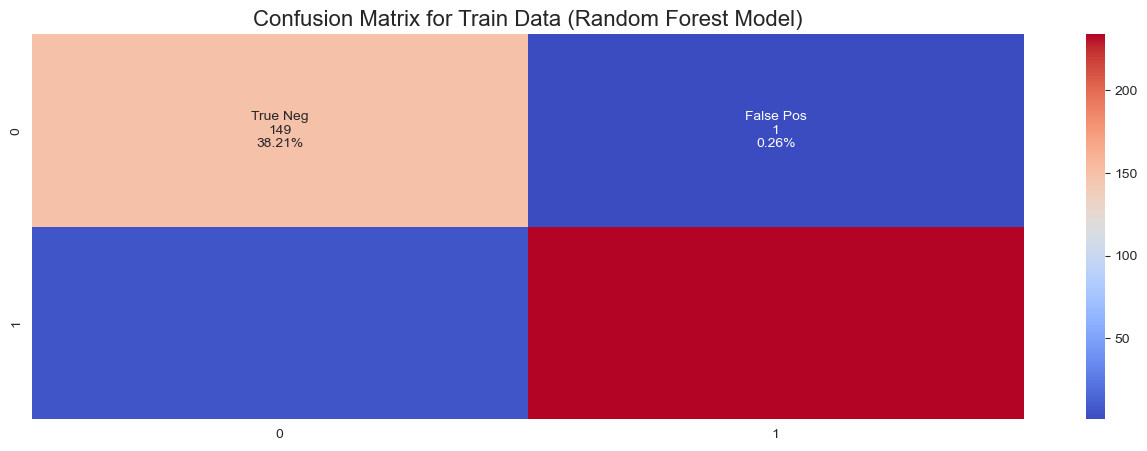

In [42]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
train_cnf_matrix = confusion_matrix(Y_train,pred_train)
train_counts = ["{0:0.0f}".format(value) for value in train_cnf_matrix.flatten()]
train_percentage = ["{0:.2%}".format(value) for value in train_cnf_matrix .flatten()/np.sum(train_cnf_matrix)]
train_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,train_counts,train_percentage)]
train_labels = np.asarray(train_labels).reshape(2,2)
plt.figure(figsize = (16,5))
sns.heatmap(train_cnf_matrix, annot=train_labels, fmt='', cmap='coolwarm')
plt.title('Confusion Matrix for Train Data (Random Forest Model)',fontsize=16);

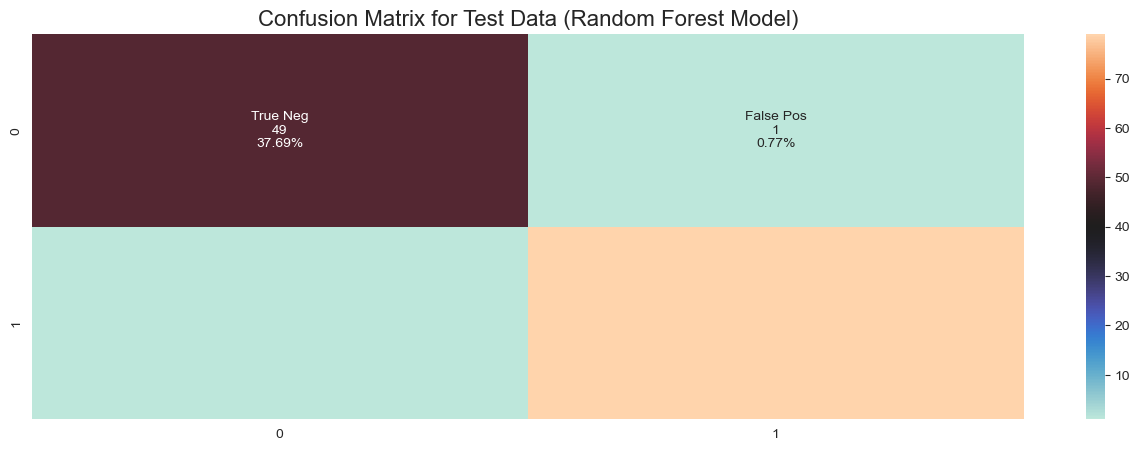

In [43]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
test_cnf_matrix = confusion_matrix(Y_test,pred_test)
test_counts = ["{0:0.0f}".format(value) for value in test_cnf_matrix.flatten()]
test_percentage = ["{0:.2%}".format(value) for value in test_cnf_matrix .flatten()/np.sum(test_cnf_matrix)]
test_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,test_counts,test_percentage)]
test_labels = np.asarray(test_labels).reshape(2,2)
plt.figure(figsize = (16,5))
sns.heatmap(test_cnf_matrix, annot=test_labels, fmt='', cmap='icefire')
plt.title('Confusion Matrix for Test Data (Random Forest Model)',fontsize=16);

* To predict who will likely to have diabetes, we prefer algorithms that can score a high probability of finding out people who
have the same characteristics and actually have diabetes later (TRUE POSITIVE). 
* Based on the severity of the illness, we may also prefer that the algorithm wrongly chooses some people who don’t get ill after all rather than miss the people who actually do get ill (FALSE POSITIVE). 

In [44]:
print(f"{classification_report(Y_train,pred_train)}")

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       150
           1       1.00      0.97      0.99       240

    accuracy                           0.98       390
   macro avg       0.98      0.98      0.98       390
weighted avg       0.98      0.98      0.98       390


In [45]:
print(f"{classification_report(Y_test,pred_test)}")

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.99      0.99      0.99        80

    accuracy                           0.98       130
   macro avg       0.98      0.98      0.98       130
weighted avg       0.98      0.98      0.98       130


# Making Prediction With New Input

In [46]:
def predict(model, inputs):
    input_df = pd.DataFrame([inputs])
    pred = model.predict(input_df)[0]
    if pred == 0:
        print('It is predicted that this patient does not have diabetes.')
    else: 
        print('It is predicted that this patient would have diabetes.')

In [47]:
male_input = {'age':25, 
               'gender':'Male', 
               'polyuria':'No', 
               'polydipsia':'No', 
               'sudden weight loss':'No',   
               'weakness':'No', 
               'polyphagia':'No', 
               'genital thrush':'No', 
               'visual blurring':'Yes',     
               'itching':'No', 
               'irritability':'No', 
               'delayed healing':'No', 
               'partial paresis':'No',
               'muscle stiffness':'Yes', 
               'alopecia':'No'}

In [48]:
predict(final_model, male_input)

It is predicted that this patient does not have diabetes.


In [49]:
female_input = {'age':25, 
               'gender':'Female', 
               'polyuria':'No', 
               'polydipsia':'No', 
               'sudden weight loss':'No',   
               'weakness':'No', 
               'polyphagia':'No', 
               'genital thrush':'No', 
               'visual blurring':'Yes',     
               'itching':'No', 
               'irritability':'No', 
               'delayed healing':'No', 
               'partial paresis':'No',
               'muscle stiffness':'Yes', 
               'alopecia':'No'}

In [50]:
predict(final_model, female_input)

It is predicted that this patient would have diabetes.


# Recommendation

* We could implement ensemble learning, such as by using voting classifier or stacking classifier.
* Randomized Search could be used to tune the hyperparameters to see if the hyperparameter combination is the same.
* If it is possible, we could increase the size of dataset by collecting more data. 

## Save Model

In [51]:
filename = '../models/finalized_svm_model_diabetes.pkl'
pickle.dump(final_model, open(filename,'wb'))

In [52]:
loaded_model = pickle.load(open(filename, 'rb'))

input_df = pd.DataFrame([female_input])
pred = loaded_model.predict(input_df)[0]
if pred == 0:
    print('It is predicted that this patient does not have diabetes.')
else: 
    print('It is predicted that this patient would have diabetes.')

It is predicted that this patient would have diabetes.
